In [ ]:
import os
from datetime import datetime

import pandas as pd
import geopandas as gpd

# read data
# PATH = '../input/ieee-bigdata-cup-2022-destination-prediction/'

import os
os.chdir('/content/drive/MyDrive/final project/ieee-bigdata-cup-2022-destination-prediction/')

def get_raw_data(zone_name):
    PATH ='./train/train/'
    if os.path.exists(PATH+zone_name+'.csv'):
        df_raw_train = pd.read_csv(PATH+zone_name+'.csv', parse_dates=['Departure_time'])
        return df_raw_train
    else:
        return []

In [ ]:
label_map = {}

with open('./label_map.csv') as f:
    for line in f:
        l = line.rstrip('\n').split(',')
        if l[0] not in ['Tokyo', 'Chukyo', 'Kyushu', 'Higashisuruga', 'Kinki']:
            print(l)
            continue
        if l[1] not in  ['Occupation', 'Trip Type']:
            print(l[1])
            continue
        if not label_map.get(l[0]):
            label_map[l[0]] = {}
        if not label_map[l[0]].get(l[1]):
            label_map[l[0]][l[1]] = {}
        if len(l) == 5 and len(l[4])>0:
            label_map[l[0]][l[1]][int(l[2])] = int(l[4])

print(label_map)

['\ufeffCity', 'Type', 'Code', 'Description', 'map_label']
{'Tokyo': {'Occupation': {1: 7, 2: 8, 3: 4, 4: 5, 5: 9, 6: 6, 7: 3, 8: 2, 9: 1, 10: 12, 11: 13, 12: 14, 13: 14, 14: 15, 15: 16, 16: 21, 99: 99}, 'Trip Type': {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 46, 7: 6, 8: 6, 9: 6, 10: 7, 11: 8, 12: 9, 13: 10, 14: 11, 99: 99}}, 'Chukyo': {'Occupation': {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 99: 99}, 'Trip Type': {1: 1, 2: 2, 3: 3, 4: 12, 5: 4, 6: 4, 7: 6, 8: 2, 9: 5, 10: 5, 11: 5, 12: 46, 13: 46, 14: 1, 15: 6, 16: 6, 17: 8, 18: 7, 19: 9, 20: 10, 21: 11, 99: 99}}, 'Kyushu': {'Occupation': {1: 2, 2: 1, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 9, 9: 8, 10: 12, 11: 13, 12: 14, 13: 15, 14: 16}, 'Trip Type': {1: 1, 2: 1, 3: 2, 4: 7, 5: 8, 6: 9, 7: 12, 8: 12, 9: 11, 10: 10, 11: 10, 12: 4, 13: 5, 14: 12, 15: 6, 16: 6, 17: 2, 18: 6, 19: 3, 20: 3, 21: 3, 22: 3}}, 'Higashisuruga': {'Occupation': {1: 7, 2: 8, 3: 4, 4: 9, 5: 5, 6: 6, 7: 3, 8: 2,

In [ ]:
def maptime(departure_time):
    if departure_time.hour < 8:
        return 0
    elif departure_time.hour < 16:
        return 1
    else:
        return 2

def get_clean_data(zone_name):
    df_raw = get_raw_data(zone_name)
    if len(df_raw) == 0:
        return df_raw

    df = df_raw.dropna()
    df.drop_duplicates(inplace = True)

    df['Occupation_washed'] = df.apply(lambda x: int(x['Occupation']) if not label_map[zone_name]['Occupation'].get(x['Occupation']) else int(label_map[zone_name]['Occupation'][x['Occupation']]), axis=1)


    df['Trip_type_washed'] = df.apply(lambda x: int(x['Trip_type']) if not label_map[zone_name]['Trip Type'].get(x['Trip_type']) else int(label_map[zone_name]['Trip Type'][x['Trip_type']]), axis=1)

    df['Departure_time_washed'] = df['Departure_time'].apply(maptime)
    df['Gender_Categorical'] = df['Gender'].map({1: 'Male', 2: 'Female'})

    catcols = df.select_dtypes(['object']).columns
    df[catcols] = df[catcols].astype('category')
    return  df

In [ ]:
def get_round_trip_label(df):
    df = df.sort_values(by=['Pid', 'Departure_time'], ascending=True)
    data_len = len(df)
    # 0: not a roundtrip  1: a round trip
    round_trip = []
    muilt_trip = []
    first_muilt = []
    last_muilt = []
    # store the last record
    cache_record = {'Pid':-1,'Departure_time':datetime(1900,1,1)}
    for i in range(data_len):
        # whether the only record
        row = df.iloc[i]
        if i+1==data_len:
            next_row = {'Pid':-1,'Departure_time':datetime(1900,1,1), 'Origin':-1, 'Destination':-1}
        else:
            next_row = df.iloc[i+1]
        if (cache_record.get('Pid') != row['Pid'] or cache_record.get('Departure_time').date() != row['Departure_time'].date()) and (i+1==data_len or ( next_row['Pid'] != row['Pid'] or next_row['Departure_time'].date() != row['Departure_time'].date() ) ):
            if(row['Origin'] != row['Destination']):
                round_trip.append(0)
            else:
                round_trip.append(1)
            muilt_trip.append(False)
            last_muilt.append(True)
        # mulit record
        else:
            muilt_trip.append(True)
            if (i+1==data_len or ( next_row['Pid'] != row['Pid'] or next_row['Departure_time'].date() != row['Departure_time'].date() ) ):
                if (row['Destination'] != cache_record['last_Origin']):
                    round_trip.append(0)
                else:
                    round_trip.append(1)
                last_muilt.append(True)
            else:
                if(row['Destination'] != next_row['Origin']):
                    round_trip.append(0)
                else:
                    round_trip.append(1)
                last_muilt.append(False)
        # update the last record
        if  cache_record.get('Pid') != row['Pid']:
            cache_record['Pid'] = row['Pid']
            cache_record['Departure_time'] = row['Departure_time']
            cache_record['last_Origin'] = row['Origin']
            cache_record['last_Destination'] = row['Destination']
            first_muilt.append(True)
        elif cache_record.get('Departure_time').date() != row['Departure_time'].date():
            cache_record['Departure_time'] = row['Departure_time']
            cache_record['last_Origin'] = row['Origin']
            cache_record['last_Destination'] = row['Destination']
            first_muilt.append(True)
        else:
            cache_record['Departure_time'] = row['Departure_time']
            cache_record['last_Destination'] = row['Destination']
            first_muilt.append(False)
    df['round_trip'] = round_trip
    df['muilt_trip'] = muilt_trip
    df['first_muilt'] = first_muilt
    df['last_muilt'] = last_muilt
    return  df

In [ ]:
def getgeoattr(df, zone_name,col_name='Origin'):
    zone_feature_path = './Zone_features/Zone_features/'
    zone_feature_dict = {}
    add_attr = ['T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
    zone_feature_file_path = zone_feature_path+zone_name+'_zone_feature_area.csv'
    with open(zone_feature_file_path, 'r') as f:
        for line in f:
            l = line.rstrip('\n').split(',')
            if l[0][0] not in [str(i) for i in range(10)]:
                print(l)
                continue
            temp = {}
            temp['Origin'] = int(l[0])
            for i,v in enumerate(add_attr):
                temp[v] = float(l[i+1])
            zone_feature_dict[int(l[0])] = temp
    df_join = []
    for i in range(len(df)):
        r = df.iloc[i]
        temp = zone_feature_dict.get(int(r[col_name]), {'Origin':int(r[col_name]), 'T000918002':-1, 'T000918006':-1, 'T000918021':-1, 'T000918025':-1, 'T000847001':-1})
        df_join.append(temp)
    df_join = pd.DataFrame(df_join)
    for v in add_attr:
        df[v] = list(df_join[v])
    return df



In [ ]:
zone_list = ['Tokyo', 'Chukyo', 'Kyushu', 'Higashisuruga', 'Kinki']
train_data = {}
for zone_name in zone_list[:4]:
    df = get_clean_data(zone_name)
    df = get_round_trip_label(df)
    df = getgeoattr(df, zone_name)
    train_data[zone_name] = df
df = get_clean_data('Kinki')
df = getgeoattr(df, zone_name)
train_data['Kinki'] = df


['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']


In [ ]:
import copy
df_all = pd.concat([train_data['Tokyo'], train_data['Chukyo'], train_data['Kyushu'],train_data['Higashisuruga']], ignore_index=True)
df_all.to_csv("df_test.csv")

<Axes: >

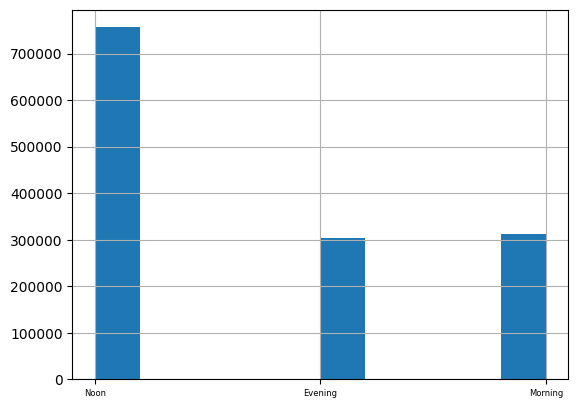

In [ ]:
df_all['Departure_time_washed'].hist(xlabelsize=6)

<Axes: >

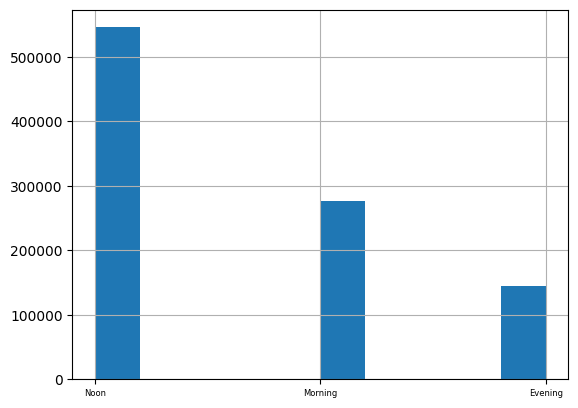

In [ ]:
train_data['Kinki']['Departure_time_washed'].hist(xlabelsize=6)

In [ ]:
rt_data = df_all[df_all['round_trip'] == 1]
nrt_data = df_all[df_all['round_trip'] == 0]

<Axes: >

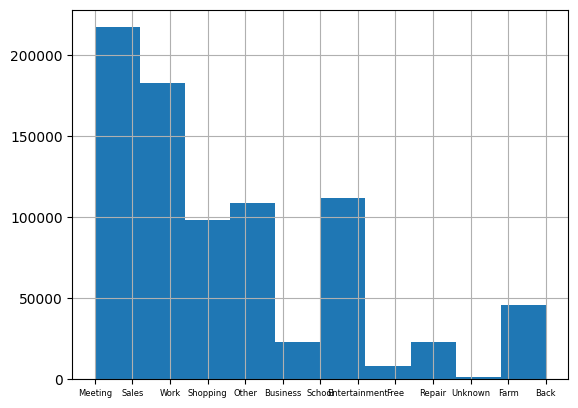

In [ ]:
rt_data['Trip_type_washed'].hist(xlabelsize=6)

<Axes: >

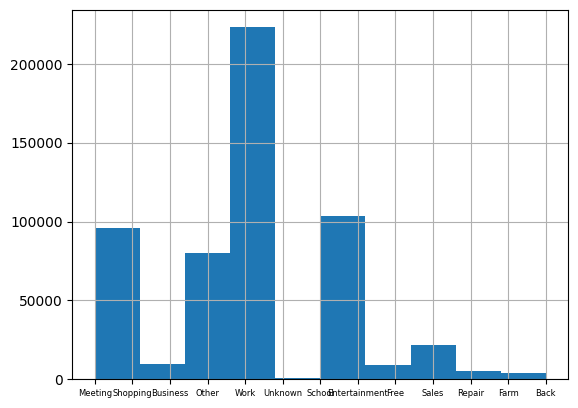

In [ ]:
nrt_data['Trip_type_washed'].hist(xlabelsize=6)

In [ ]:
m = { 1: 'To Work', 2: 'To School', \
    3: 'To Home', 4: 'To Shopping', \
    5: 'To Eat/Social/Entertainment', 6: 'Other Private Purpose (including To Hospital and Pickup)', \
    7: 'For Sales/Delivery/Restock/Purchase', 8: 'For Meeting/Withdraw/Doctors Visit', \
    9: 'Repair', 10: 'Farm Chores', \
    11: 'Other Business Purpose', 12: 'Back to Work/School', \
    46: 'Free Purpose', \
    99: 'Unknown'}
df = {'label':[], 'round':[], 'non':[]}
for k in m:
  df['label'].append(m[k])
  total = len(df_all[df_all['Trip_type_washed']==k])
  p = 0 if total == 0 else len(rt_data[rt_data['Trip_type_washed']==k])/total
  df['round'].append(p*100)
  p = 0 if total == 0 else  len(nrt_data[nrt_data['Trip_type_washed']==k])/total
  df['non'].append(p*100)
df = pd.DataFrame(df)
df

,label,round,non
0,To Work,45.017694,54.982306
1,To School,50.520023,49.479977
2,To Home,0.000000,0.000000
3,To Shopping,53.154147,46.845853
4,To Eat/Social/Entertainment,53.970885,46.029115
5,Other Private Purpose (including To Hospital a...,57.663472,42.336528
6,For Sales/Delivery/Restock/Purchase,88.007344,11.992656
7,For Meeting/Withdraw/Doctors Visit,85.937094,14.062906
8,Repair,81.959169,18.040831
9,Farm Chores,93.052734,6.947266


In [ ]:
m = { 1: 'Managers', 2: 'Technicians and Professionals', \
    3: 'Clerical Assistants', 4: 'Sales', \
    5: 'Services', 6: 'Security Inspectors', \
    7: 'Argriculture Forestry and Fishery', 8: 'Laborer', \
    9: 'Transport', 10: 'Architecture and Mining Workers', \
    11: 'Porter Cleaner and Packer', 12: 'Other Occupation', \
    13: 'Preschoolers Elementary and Middle School Students', 14: 'High School Students and above', \
    15: 'Homemakers', 16: 'Inoccupation', \
    21: 'Employed(Detail Unknown)', 99: 'Unknown'}
df = {'label':[], 'round':[], 'non':[]}
for k in m:
  df['label'].append(m[k])
  total = len(df_all[df_all['Occupation_washed']==k])
  p = 0 if total == 0 else len(rt_data[rt_data['Occupation_washed']==k])/total
  df['round'].append(p*100)
  p = 0 if total == 0 else  len(nrt_data[nrt_data['Occupation_washed']==k])/total
  df['non'].append(p*100)
df = pd.DataFrame(df)
df

,label,round,non
0,Managers,58.251137,41.748863
1,Technicians and Professionals,55.044208,44.955792
2,Clerical Assistants,55.278756,44.721244
3,Sales,67.738935,32.261065
4,Services,59.223923,40.776077
5,Security Inspectors,57.090086,42.909914
6,Argriculture Forestry and Fishery,72.879942,27.120058
7,Laborer,59.032731,40.967269
8,Transport,61.116023,38.883977
9,Architecture and Mining Workers,46.070812,53.929188


<Axes: >

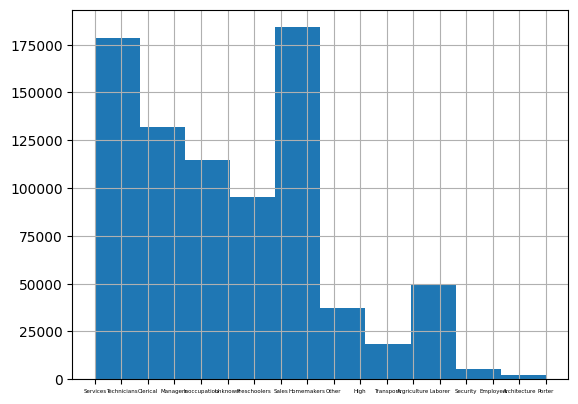

In [ ]:
rt_data['Occupation_washed'].hist(xlabelsize=4)

<Axes: >

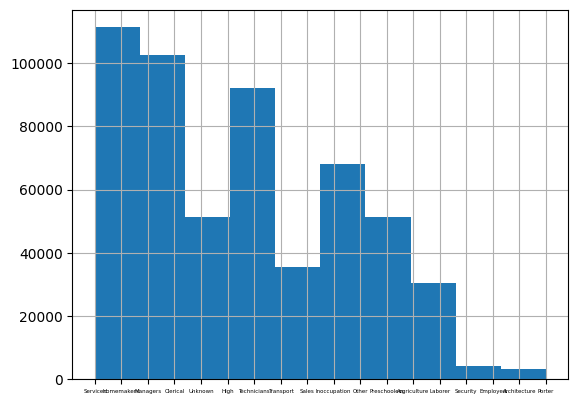

In [ ]:
nrt_data['Occupation_washed'].hist(xlabelsize=4)

# trip record analysis

In [ ]:
zone_feature = {}
for zone_name in zone_list:
  zone_feature_path = './Zone_features/Zone_features/'
  zone_feature_file_path = zone_feature_path+zone_name+'_zone_feature_area.csv'
  df = pd.read_csv(zone_feature_file_path)
  zone_feature[zone_name] =df
zf_all = pd.concat([zone_feature['Tokyo'], zone_feature['Chukyo'], zone_feature['Kyushu'],zone_feature['Higashisuruga'],zone_feature['Kinki']], ignore_index=True)
zf_all.corr()

,ZONE_ID,T000918002,T000918006,T000918021,T000918025,T000847001
ZONE_ID,1.000000,-0.162691,-0.085679,-0.129179,-0.095520,-0.188136
T000918002,-0.162691,1.000000,0.653958,0.705365,0.568433,0.594927
T000918006,-0.085679,0.653958,1.000000,0.713272,0.912627,0.367312
T000918021,-0.129179,0.705365,0.713272,1.000000,0.809929,0.280525
T000918025,-0.095520,0.568433,0.912627,0.809929,1.000000,0.215985
T000847001,-0.188136,0.594927,0.367312,0.280525,0.215985,1.000000


In [ ]:
df = get_clean_data('Kinki')
df = getgeoattr(df, zone_name)
train_data['Kinki'] = df
len(train_data['Kinki'])

['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']


967459

In [ ]:
df_all.describe()

,Pid,Departure_time,Gender,Age,Occupation,Trip_type,Origin,Destination,Occupation_washed,Trip_type_washed,Departure_time_washed,round_trip,T000918002,T000918006,T000918021,T000918025,T000847001
count,1.374291e+06,1374291,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06,1.374291e+06
mean,2.091109e+05,2008-08-27 17:07:48.172810240,1.523329e+00,8.421823e+00,9.779918e+00,4.926978e+00,3.205539e+04,3.076928e+04,9.533503e+00,5.084943e+00,9.935771e-01,5.972265e-01,4.700013e+01,4.329322e+02,7.285363e+02,6.694915e+03,7.536464e+03
min,1.000000e+00,2005-10-03 03:00:00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+02,1.000000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,8.097900e+04,2005-10-03 23:45:00,1.000000e+00,6.000000e+00,5.000000e+00,1.000000e+00,8.211000e+03,7.202000e+03,3.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.265557e+01,5.649633e+01,1.191133e+02,5.354343e+02,2.323733e+03
50%,1.612780e+05,2008-10-01 09:15:00,2.000000e+00,8.000000e+00,9.000000e+00,4.000000e+00,2.110100e+04,2.010300e+04,8.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.823706e+01,1.636921e+02,2.737479e+02,1.584401e+03,6.535842e+03
75%,3.247405e+05,2008-10-01 16:35:00,2.000000e+00,1.200000e+01,1.300000e+01,7.000000e+00,4.411200e+04,4.310100e+04,1.500000e+01,7.000000e+00,1.000000e+00,1.000000e+00,5.412786e+01,3.614265e+02,6.548319e+02,3.549353e+03,1.139471e+04
max,5.885680e+05,2016-12-02 02:30:00,2.000000e+00,1.700000e+01,9.900000e+01,9.900000e+01,1.701060e+05,1.901010e+05,9.900000e+01,9.900000e+01,2.000000e+00,1.000000e+00,7.399521e+02,7.422313e+03,2.423700e+04,1.846953e+05,3.161685e+04
std,1.620075e+05,NaN,4.994556e-01,3.936428e+00,9.967697e+00,5.481615e+00,3.166625e+04,3.223404e+04,1.054372e+01,6.759465e+00,6.704199e-01,4.904561e-01,6.272978e+01,8.986167e+02,1.645188e+03,1.916672e+04,6.156040e+03


<Axes: ylabel='Frequency'>

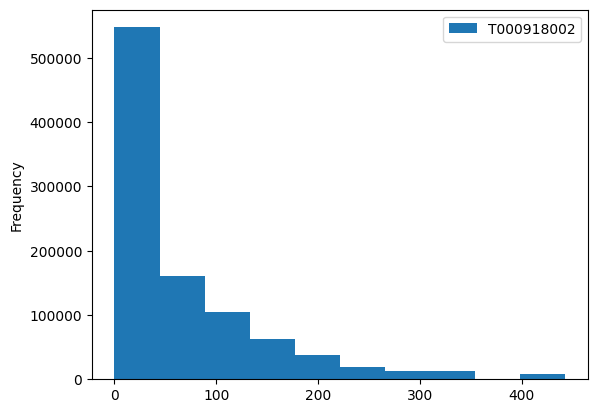

In [ ]:
train_data['Kinki'].plot(kind='hist', column='T000918002')
# train_data['Tokyo'].plot(kind='hist', column='T000918002')

In [ ]:
def get_freq_data(zone_df, zone_name, col_name='ZONE_ID'):
  d = {}
  d_o = {}
  d_d = {}
  df = get_raw_data(zone_name=zone_name)
  for i,row in df.iterrows():
    index = int(row['Origin'])
    d[index] = d.get(index, 0) + 1
    d_o[index] = d_o.get(index, 0) + 1
    if 'Destination' in row.keys():
      index = int(row['Destination'])
      d[index] = d.get(index, 0) + 1
      d_d[index] = d_d.get(index, 0) + 1
  df_join = []
  o_join = []
  d_join = []
  for i in range(len(zone_df)):
      r = zone_df.iloc[i]
      temp = d.get(int(r[col_name]), 0)
      df_join.append(temp)
      temp_o = d_o.get(int(r[col_name]), 0)
      o_join.append(temp_o)
      temp_d = d_d.get(int(r[col_name]), 0)
      d_join.append(temp_d)
  zone_df['freq'] = list(df_join)
  zone_df['origin_freq'] = list(o_join)
  zone_df['dest_freq'] = list(d_join)
  return zone_df

In [ ]:
zone_path = './Zones/Zones/'
zone_list = ['Tokyo', 'Chukyo', 'Kyushu', 'Higashisuruga', 'Kinki']
geodataframe_data = {}
for zone_name in zone_list:
    zone_pd = gpd.read_file(zone_path+zone_name+'/'+zone_name+'.shp')
    zone_pd = getgeoattr(zone_pd, zone_name,col_name='ZONE_ID')
    zone_pd = get_freq_data(zone_pd, zone_name)
    geodataframe_data[zone_name] = zone_pd


['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']


In [ ]:
geodataframe_data['Tokyo'][['origin_freq','dest_freq']].corr()

,origin_freq,dest_freq
origin_freq,1.000000,0.813921
dest_freq,0.813921,1.000000


In [ ]:
geodataframe_data['Chukyo'][['origin_freq','dest_freq']].corr()

,origin_freq,dest_freq
origin_freq,1.000000,0.743918
dest_freq,0.743918,1.000000


In [ ]:
geodataframe_data['Kyushu'][['origin_freq','dest_freq']].corr()

,origin_freq,dest_freq
origin_freq,1.000000,0.996793
dest_freq,0.996793,1.000000


In [ ]:
geodataframe_data['Higashisuruga'][['origin_freq','dest_freq']].corr()

,origin_freq,dest_freq
origin_freq,1.000000,0.908387
dest_freq,0.908387,1.000000


<Axes: >

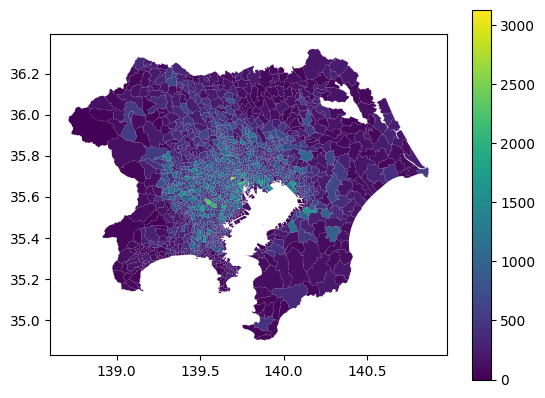

In [ ]:
geodataframe_data['Tokyo'].plot(column='origin_freq',legend=True)

<Axes: >

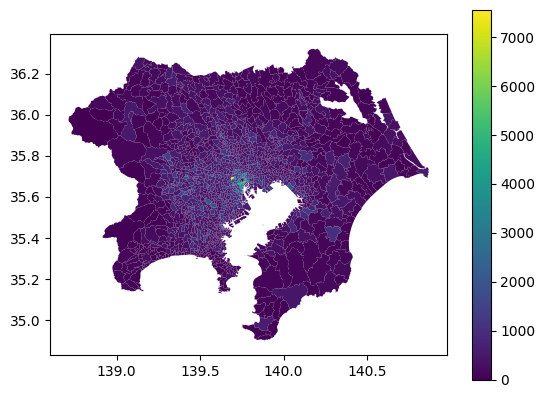

In [ ]:
geodataframe_data['Tokyo'].plot(column='dest_freq',legend=True)

<Axes: >

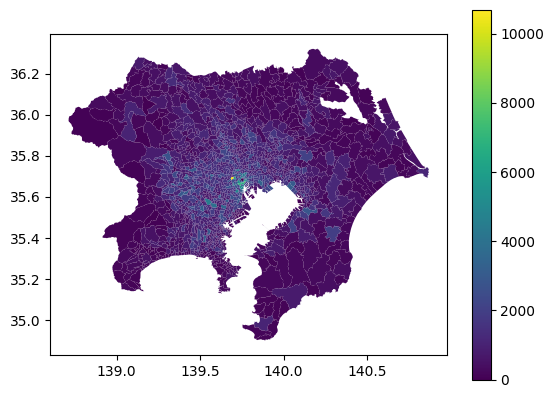

In [ ]:
geodataframe_data['Tokyo'].plot(column='freq',legend=True)

<Axes: >

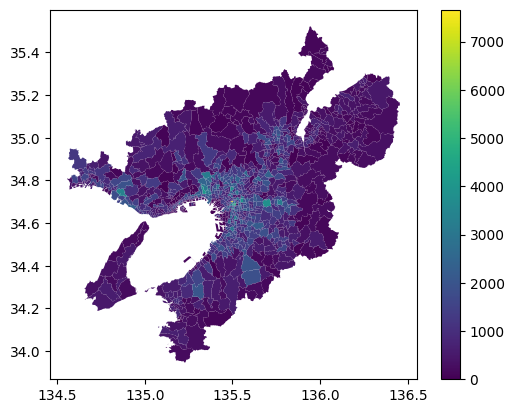

In [ ]:
geodataframe_data['Kinki'].plot(column='freq',legend=True)

<Axes: >

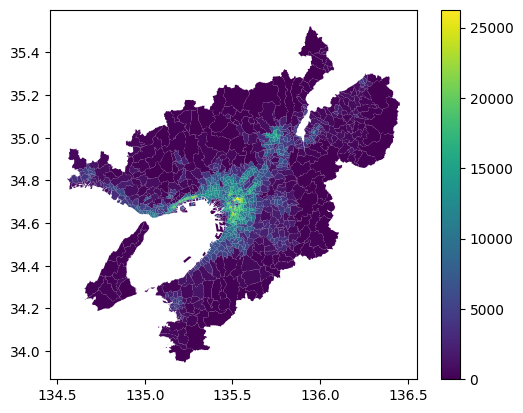

In [ ]:
geodataframe_data['Kinki'].plot(column='T000847001',legend=True)

In [ ]:
def getdistance(df, zone_name):
  zone_path = './Zones/Zones/'
  zone_pd = gpd.read_file(zone_path+zone_name+'/'+zone_name+'.shp')
  d = {}
  for i,row in zone_pd.iterrows():
    d[int(row['ZONE_ID'])] = row['geometry']
  l = []
  for i,row in df.iterrows():
    origin,dest = int(row['Origin']), int(row['Destination'])
    l.append(d[origin].distance(d[dest]))
  df['distance'] = l
  return df

In [ ]:
zone_list = ['Tokyo', 'Chukyo', 'Kyushu', 'Higashisuruga', 'Kinki']
for zone_name in zone_list[:4]:
    train_data[zone_name] = getdistance(train_data[zone_name], zone_name)


KeyboardInterrupt: 

In [ ]:
train_data['Tokyo']['distance'].hist()

In [ ]:
df_all = pd.concat([train_data['Tokyo'], train_data['Chukyo'], train_data['Kyushu'],train_data['Higashisuruga']], ignore_index=True)
nrt_data = df_all[df_all['round_trip'] == 0]

In [ ]:
nrt_data['distance'].hist()

In [ ]:
len(nrt_data[nrt_data['distance']<0.1])/len(nrt_data)

In [ ]:
catcols = df_all.select_dtypes(['object']).columns
df_all[catcols] = df_all[catcols].astype('category')
df_all.info()

In [ ]:
train_data['Tokyo'].info()

# Round-Trip classification

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
# features = ['Gender', 'Age', 'Occupation_washed', 'Trip_type_washed', 'Departure_time_washed', 'muilt_trip', 'T000918002', 'T000918006', 'T000918021', 'T000847001']
trip_map = { 1: 'To_Work', 2: 'To_School', \
    3: 'To_Home', 4: 'To_Shopping', \
    5: 'To_Eat/Social/Entertainment', 6: 'Other_Private_Purpose_(including_To_Hospital_and_Pickup)', \
    7: 'For_Sales/Delivery/Restock/Purchase', 8: 'For_Meeting/Withdraw/Doctors_Visit', \
    9: 'Repair', 10: 'Farm_Chores', \
    11: 'Other_Business_Purpose', 12: 'Back_to_Work/School', \
    46: 'Free_Purpose', \
    99: 'Unknown'}

occupation_map = { 1: 'Managers', 2: 'Technicians_and_Professionals', \
    3: 'Clerical_Assistants', 4: 'Sales', \
    5: 'Services', 6: 'Security_Inspectors', \
    7: 'Argriculture_Forestry_and_Fishery', 8: 'Laborer', \
    9: 'Transport', 10: 'Architecture_and _Mining_Workers', \
    11: 'Porter_Cleaner_and_Packer', 12: 'Other_Occupation', \
    13: 'Preschoolers_Elementary_and_Middle_School_Students', 14: 'High_School_Students_and_above', \
    15: 'Homemakers', 16: 'Inoccupation', \
    21: 'Employed(Detail_Unknown)', 99: 'Unknown'}

departure_time_map = {0: 'Morning', 1: 'Noon', 2: 'Evening'}

features = ['Gender', 'Age', 'muilt_trip', 'first_muilt', 'last_muilt', 'T000918002', 'T000918006', 'T000918021', 'T000847001']
for v in trip_map:
   features.append('one_hot_Trip_type_washed_'+trip_map[v])
for v in occupation_map:
   features.append('one_hot_Occupation_washed_'+occupation_map[v])
for v in departure_time_map:
   features.append('one_hot_Departure_time_washed_'+departure_time_map[v])



def onehotencode(df, m, col_name):
  for v in m:
    df['one_hot_'+col_name+'_'+m[v]] = df[col_name]==v
  return df



# df_train = df_all[~df_all.Trip_type_washed.isin([10,12,7,8,9])]
# df_train = df_all[df_all.Trip_type_washed != 10]
df_all = pd.concat([train_data['Tokyo'], train_data['Chukyo'], train_data['Kyushu'],train_data['Higashisuruga']], ignore_index=True)
df_train = df_all
df_train = onehotencode(df_train, trip_map, 'Trip_type_washed')
df_train = onehotencode(df_train, occupation_map, 'Occupation_washed')
df_train = onehotencode(df_train, departure_time_map, 'Departure_time_washed')

# Test Accuracy

In [ ]:
dtree = DecisionTreeClassifier()
x = df_train
y = df_train[['Trip_type_washed','round_trip']]
# trip = [10,12,7,8,9]
trip = [10,12]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train = x_train[~x_train.Trip_type_washed.isin(trip)]
y_train = y_train[~y_train.Trip_type_washed.isin(trip)]
dtree.fit(x_train[features], y_train['round_trip'])
y_dp = dtree.predict(x_test[features])
for i,v in enumerate(list(x_test['Trip_type_washed'])):
  if v in trip:
    y_dp[i] = 1
print(accuracy_score(y_dp, y_test['round_trip']))
confusion_matrix(y_dp, y_test['round_trip'])

0.7924604087049913


array([[104457,  37202],
       [ 34103, 167811]])

# Train Accuracy

In [ ]:
y_dp = dtree.predict(x_train[features])
for i,v in enumerate(list(x_train['Trip_type_washed'])):
  if v in trip:
    y_dp[i] = 1
print(accuracy_score(y_dp, y_train['round_trip']))
confusion_matrix(y_dp, y_train['round_trip'])

0.9512478060304331


array([[396100,  32735],
       [ 15679, 548549]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
dtree_non = DecisionTreeClassifier(criterion='entropy')
dtree_non.fit(x_train[features], y_train['round_trip'])
y_dp = dtree_non.predict(x_test[features])
print(accuracy_score(y_dp, y_test['round_trip']))
confusion_matrix(y_dp, y_test['round_trip'])

0.7947335791811347


array([[105067,  37140],
       [ 33384, 167982]])

In [ ]:
y_dp = dtree_non.predict(x_train[features])
print(accuracy_score(y_dp, y_train['round_trip']))
confusion_matrix(y_dp, y_train['round_trip'])

0.9527572042013431


array([[399211,  32828],
       [ 15866, 582813]])

In [ ]:
logreg = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train = x_train[~x_train.Trip_type_washed.isin(trip)]
y_train = y_train[~y_train.Trip_type_washed.isin(trip)]
logreg.fit(x_train[features], y_train['round_trip'])
y_lp = logreg.predict(x_test[features])
for i,v in enumerate(list(x_test['Trip_type_washed'])):
  if v in trip:
    y_lp[i] = 1
print(accuracy_score(y_lp, y_test['round_trip']))
confusion_matrix(y_lp, y_test['round_trip'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.772537422905758


array([[ 85793,  25333],
       [ 52817, 179630]])

In [ ]:
y_lp = logreg.predict(x_train[features])
for i,v in enumerate(list(x_train['Trip_type_washed'])):
  if v in trip:
    y_lp[i] = 1
print(accuracy_score(y_lp, y_train['round_trip']))
confusion_matrix(y_lp, y_train['round_trip'])

0.7676189018465018


array([[257589,  76618],
       [154152, 504708]])

In [ ]:
logreg_non = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
logreg_non.fit(x_train[features], y_train['round_trip'])
y_lp = logreg_non.predict(x_test[features])
print(accuracy_score(y_lp, y_test['round_trip']))
confusion_matrix(y_lp, y_test['round_trip'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7767315825166704


array([[ 88078,  26601],
       [ 50108, 178786]])

In [ ]:
y_lp = logreg_non.predict(x_train[features])
print(accuracy_score(y_lp, y_train['round_trip']))
confusion_matrix(y_lp, y_train['round_trip'])

0.7768730147334189


array([[263761,  78400],
       [151581, 536976]])

In [ ]:
x_train[features].head()

,Gender,Age,muilt_trip,first_muilt,last_muilt,T000918002,T000918006,T000918021,T000847001,one_hot_Trip_type_washed_To_Work,...,one_hot_Occupation_washed_Other_Occupation,one_hot_Occupation_washed_Preschoolers_Elementary_and_Middle_School_Students,one_hot_Occupation_washed_High_School_Students_and_above,one_hot_Occupation_washed_Homemakers,one_hot_Occupation_washed_Inoccupation,one_hot_Occupation_washed_Employed(Detail_Unknown),one_hot_Occupation_washed_Unknown,one_hot_Departure_time_washed_Morning,one_hot_Departure_time_washed_Noon,one_hot_Departure_time_washed_Evening
411916,2,7,False,True,True,59.407919,734.921307,837.171709,17749.918224,False,...,False,False,False,True,False,False,False,False,True,False
894899,1,3,False,True,True,12.346446,56.548553,195.884320,2514.628284,False,...,False,False,True,False,False,False,False,True,False,False
942143,2,6,True,True,False,97.926142,588.098627,1055.878584,9868.840700,True,...,False,False,False,False,False,False,False,False,True,False
751029,2,13,True,True,False,-1.000000,-1.000000,-1.000000,-1.000000,False,...,False,False,False,False,False,False,False,False,True,False
482810,1,15,False,True,True,39.816170,113.907730,851.550845,5526.838796,False,...,False,False,False,False,True,False,False,False,True,False


# Destination Prediction

## choose the popular origin from 0.1 radus

In [ ]:
def get_orig_freq_data(df):
  res = {}
  for i,row in df.iterrows():
    index = int(row['Origin'])
    res[index] = res.get(index, 0) + 1
  return res

In [ ]:
from functools import cache
from collections import defaultdict
def get_radus(zone_name, radius=0.1):
  zone_path = './Zones/Zones/'
  zone_pd = gpd.read_file(zone_path+zone_name+'/'+zone_name+'.shp')
  zone_map = {}
  for i,row in zone_pd.iterrows():
    zone_map[int(row['ZONE_ID'])] = row['geometry']
  res = defaultdict(list)
  s = set()
  @cache
  def get_distance(x,y):
    if (y,x) in s:
      return get_distance(y,x)
    else:
      d = zone_map[x].distance(zone_map[y])
      s.add((x,y))
      return d
  for zone_x in zone_map:
    for zone_y in zone_map:
      if zone_x != zone_y and get_distance(zone_x, zone_y) <= radius:
        res[zone_x].append(zone_y)
  return res

In [ ]:
freq_map = get_orig_freq_data(train_data['Tokyo'])

In [ ]:
radius_map = get_radus('Tokyo', radius=0.1)

In [ ]:
nrt_data = train_data['Tokyo'][train_data['Tokyo']['round_trip'] == 0]

In [ ]:
from heapq import heappush
pred_dest = []
for i,row in nrt_data.iterrows():
  heap = []
  for potenial_dest in radius_map[int(row['Origin'])]:
    if potenial_dest in freq_map:
      heappush(heap, (-freq_map[potenial_dest], potenial_dest))
  pred_dest.append(heap[0][1])

In [ ]:
print(accuracy_score(pred_dest, nrt_data['Destination']))

0.017002560231077265


In [ ]:
nrt_data[['Gender', 'Age', 'muilt_trip', 'first_muilt', 'last_muilt', 'T000918002', 'T000918006', 'T000918021', 'T000847001','Origin', 'Destination']]

,Gender,Age,muilt_trip,first_muilt,last_muilt,T000918002,T000918006,T000918021,T000847001,Origin,Destination
673931,1,4,True,False,True,128.735198,3527.181556,18151.752537,102.987980,103,32200
658772,2,14,False,True,True,432.416689,4743.141973,10259.441055,9727.599221,123,3231
671860,1,12,True,False,True,50.396136,1607.310595,3285.225513,3164.807818,110,111
668022,2,9,False,True,True,66.641839,1037.701919,2553.747536,16622.490019,2301,121
668023,2,9,False,True,True,425.221981,5223.630314,10495.242240,5754.000888,121,2350
...,...,...,...,...,...,...,...,...,...,...,...
140888,1,11,True,False,True,-1.000000,-1.000000,-1.000000,-1.000000,51140,51141
139138,1,7,True,False,True,5.257278,20.833296,127.113047,779.589527,43134,43132
141967,2,11,True,True,False,-1.000000,-1.000000,-1.000000,-1.000000,54220,54100
141970,2,11,True,False,True,-1.000000,-1.000000,-1.000000,-1.000000,54212,54212


In [ ]:
mulit_nrt_df = nrt_data[nrt_data['muilt_trip']]
len(mulit_nrt_df[mulit_nrt_df['Origin'] == mulit_nrt_df['Destination']])/len(mulit_nrt_df)

0.13378150871569983

In [ ]:
len(mulit_nrt_df)/len(nrt_data)

0.4364234531306021

In [ ]:
from collections import defaultdict
s = defaultdict(int)
for i,row in nrt_data.iterrows():
  s[(row['Origin'], row['Destination'])] += 1
len(s)/len(nrt_data)

0.3771770801246282

In [189]:
def get_round_trip_label_pred(df):
    df = df.sort_values(by=['Pid', 'Departure_time'], ascending=True)
    data_len = len(df)
    # 0: not a roundtrip  1: a round trip
    pred_dest = []
    muilt_trip = []
    first_muilt = []
    last_muilt = []
    # store the last record
    cache_record = {'Pid':-1,'Departure_time':datetime(1900,1,1)}
    for i in range(data_len):
        # whether the only record
        row = df.iloc[i]
        if i+1==data_len:
            next_row = {'Pid':-1,'Departure_time':datetime(1900,1,1), 'Origin':-1, }
        else:
            next_row = df.iloc[i+1]
        if (cache_record.get('Pid') != row['Pid'] or cache_record.get('Departure_time').date() != row['Departure_time'].date()) and (i+1==data_len or ( next_row['Pid'] != row['Pid'] or next_row['Departure_time'].date() != row['Departure_time'].date() ) ):
            pred_dest.append(row['Origin'])
            muilt_trip.append(False)
            last_muilt.append(True)
        # mulit record
        else:
            muilt_trip.append(True)
            if (i+1==data_len or ( next_row['Pid'] != row['Pid'] or next_row['Departure_time'].date() != row['Departure_time'].date() ) ):
                pred_dest.append(cache_record['last_Origin'])
                last_muilt.append(True)
            else:
                pred_dest.append(next_row['Origin'])
                last_muilt.append(False)
        # update the last record
        if  cache_record.get('Pid') != row['Pid']:
            cache_record['Pid'] = row['Pid']
            cache_record['Departure_time'] = row['Departure_time']
            cache_record['last_Origin'] = row['Origin']
            first_muilt.append(True)
        elif cache_record.get('Departure_time').date() != row['Departure_time'].date():
            cache_record['Departure_time'] = row['Departure_time']
            cache_record['last_Origin'] = row['Origin']
            first_muilt.append(True)
        else:
            cache_record['Departure_time'] = row['Departure_time']
            first_muilt.append(False)
    df['pred_dest'] = pred_dest
    df['muilt_trip'] = muilt_trip
    df['first_muilt'] = first_muilt
    df['last_muilt'] = last_muilt
    return  df

In [186]:
from collections import defaultdict
def get_pred_dest(df):
  df=get_round_trip_label_pred(df)
  s = defaultdict(int)
  for i,row in df.iterrows():
    s[(row['Origin'], row['pred_dest'])] += 1
  d = defaultdict(list)
  for i in s:
    d[i[0]].append([i[1],s[i]])
  df = onehotencode(df, trip_map, 'Trip_type_washed')
  df = onehotencode(df, occupation_map, 'Occupation_washed')
  df = onehotencode(df, departure_time_map, 'Departure_time_washed')
  y_lp = logreg_non.predict(df[features])
  df['round_trip'] = y_lp
  pred_dest = []
  for i,row in df.iterrows():
    pred_dest.append(row['pred_dest'])
    if row['round_trip'] == 0:
      if row['Origin'] in d:
        pred_dest[-1] = sorted(d[row['Origin']], key=lambda x: x[1], reverse=True)[0][0]
  return pred_dest

In [187]:
for zone in zone_list[:4]:
  pred_dest = get_pred_dest(train_data[zone])
  print(accuracy_score(pred_dest, train_data[zone]['Destination']))

0.4994415725519312
0.42957139727894467
0.9327179582658176
0.4939703153988868


In [190]:
pred_dest = get_pred_dest(train_data[zone_list[-1]])